<a href="https://colab.research.google.com/github/DataSpott/SGT-Analysis/blob/master/SGT_Automatisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ToDo-List
-> write output -> user can download results (plots of raw_data + fitted curve + tangent, table with SGT/log-level-reduction/FICI-value for all wells, average FICI-Values)

-> investigate "CutOff" to automate it

-> finetune the plotting (showing red dot where µ_max is and the tangent) -> create dataframe from data, named data_plot or show, which contains a column with the µ_max closest value of each curve at the corresponding time and a column with y-values (over all time-values) for the tangent for each curve (-> well) 

-> finetune alternative plotting

# Initialization
Installation and import of the necessary libraries/tools.
Hit the play-button on the left-hand side to start.

In [220]:
#import of the necessary python-modules for computing the data
import pandas as pd
import numpy as np
import altair as alt
import xlrd as rd
import string
import subprocess as sub
import altair_saver
#!pip install altair_saver
!pip install selenium
!apt-get install chromium-chromedriver

from scipy.optimize import curve_fit

Reading package lists... Done
Building dependency tree       
Reading state information... Done
chromium-chromedriver is already the newest version (83.0.4103.61-0ubuntu0.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


#Optional download of test-data

In [ ]:
!git clone https://github.com/DataSpott/SGT-Analysis.git

fatal: destination path 'SGT-Analysis' already exists and is not an empty directory.


# Data upload
Upload your raw-data .xls-file by clicking the play button and browse for your data.


In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving 04.04.2019_Bk14073_Nitro 0-128_Dalba 0-8_Sunrise_rawdata.xlsx to 04.04.2019_Bk14073_Nitro 0-128_Dalba 0-8_Sunrise_rawdata.xlsx
User uploaded file "04.04.2019_Bk14073_Nitro 0-128_Dalba 0-8_Sunrise_rawdata.xlsx" with length 74404 bytes


# Converting/Parsing
Converts the uploaded Excel-file into an CSV-file.

In [3]:
#convert the Excel-file into a .csv-file (.csv-file = Pandas dataframe):
data_xls = pd.read_excel(fn, sheet_name=0)                                      #variable which refers the first worksheet of the Excel-file with the name 'fn'
data_xls.to_csv('data.csv', encoding = 'utf-8')                                 #converts the Excel- to an .csv-file using the 'utf-8' encoding (for handling of special characters)

#check if .csv-file was created:
test = pd.read_csv('data.csv')                                                  #sets a test variable, which refers the created .csv-file
try:                                                                            #tries if the variable 'test' exists and give a True or False back
    test
except NameError:
    test_exists = False
else:
    test_exists = True

#depending on existence of .csv-file give confirmation back to user:
if test_exists == True:                                                         #if the test for the existence of 'test' was succesful the user gets informed that the conversion is done.
    print("Conversion of %s to .csv-file successful." %(fn))                    #Otherwise she/he is informed that the conversion failed.
else:
        print("Conversion of %s to .csv-file failed." %(fn))

Conversion of 04.04.2019_Bk14073_Nitro 0-128_Dalba 0-8_Sunrise_rawdata.xlsx to .csv-file successful.


#  Dataframe-creation
Creates a dataframe from the converted .csv-file.

In [4]:
if pd.notna(data_xls.iloc[0, 0]):
    
    #initialize list with A-Z and a variable count of numbers:
    letter_list = list(string.ascii_uppercase)
    number_list = np.linspace(1, 50, 50)

    #combines the letters with the numbers to get a list of possible well-names:
    #creates first empty main-array:
    possible_wells = []

    #primary for-loop over all letters:
    for letter in letter_list:
    
        #secondary for-loop over all numbers:
        for number in number_list:
        
            #combines the acutal letter and number and appends it to main-array:
            possible_well = letter + str(int(number))
            possible_wells.append(possible_well)

    #variable that references the name of the first column of the dataframe 'data_xls':
    first_column_name = data_xls.columns[0]

    #creates second empty main-array:
    well_index_list = []

    #for-loop over all possible wells:
    for well in possible_wells:
    
       #searches the actual possible well in the dataframe 'data_xls' and gets the index:
       index = data_xls.loc[data_xls[first_column_name] == well, [first_column_name]].index.tolist()
    
       #checks if the resulting index is not empty (so that the well was found in the dataframe):
       if len(index) > 0:
        
           #if TRUE the well-name and index are attached to the second main-array
           well_index_list.append([well, index])

    #creates third main- and a helper-array:
    time_list = []
    get_time_list = []

    #extract the time-data from the dataframe in the helper-array: 
    get_time_list.extend(data_xls.iloc[(int(well_index_list[0][1][0]) + 1), 1:])

    #append helper-array to third main-array:
    time_list.append(['Well', get_time_list])

    #creates fourth empty main-array:
    well_values = []

    #for-loop over all wells found in the dataframe:
    for well in range(len(well_index_list)):
    
        #gets the name of the actual well:
        well_name = well_index_list[well][0]
    
        #checks if the number in the well_name is < 10:
        if int(well_name[1:]) < 10:
            
            #if TRUE a 0 is added after the letter:
            well_name = well_name[0] + '0' + well_name[1:]
    
        #appends well-name and the corresponding values to the fourth main-array:
        well_values.append([well_name, list(data_xls.iloc[(int(well_index_list[well][1][0]) + 3), 1:].values)])

    #extends the list with the time-data with the value-data of the wells:
    time_list.extend(well_values)

    #creates empt dictionary:
    raw_data_dict = {}

    #for-loop over all elements in the extended time_list:
    for elements in range(len(time_list)):
    
        #sets the well-name (or in case of the time-data the string 'Well') as keys for their values in the dicitionary:
        raw_data_dict[str(time_list[elements][0])] = time_list[elements][1]

    #creates dataframe 'data_raw' with the dictionary:
    data_raw = pd.DataFrame(raw_data_dict)

    #transposes the dataframe:
    data_raw = data_raw.transpose()

    #sets the index to the first column:
    data_raw.reset_index(level=0, inplace=True)

    #sets the first row as column-names:
    data_raw.columns = data_raw.iloc[0]

    #deletes the first row
    data_raw = data_raw[1:]

    #displays dataframe 'data_raw':
    print(data_raw)#[data_raw['Well'] == input("Choose well by entering the well-name (e.g.: 'A01'): ")] #Optional: only a User-chosen Well is displayed


elif pd.isna(data_xls.iloc[0, 0]):
    #Build a pandas dataframe from the .csv-file:
    data_raw = pd.read_csv('data.csv')                                              #creates a dataframe from the .csv-file

    #deletes rows with unnecessary information (temp.-values and measurement-data):
    data_raw = data_raw[:-5]                                                        #removes last 5 rows of the dataframe (-> measurment data)
    data_raw = data_raw.iloc[1:]                                                    #removes the first row (-> temp.-values) by skipping it

    #brings the dataframe in an optimised form for plotting:
    data_raw = data_raw.rename(columns={'Unnamed: 0.1': 'Well'})                    #renames the column 'Unnamed: 0.1' to 'Well'
    del data_raw['Unnamed: 0']                                                      #deletes the column with the name 'Unnamed: 0'

    #deletes the 's' from the time-values:
    for index in range(len(data_raw.columns)):                                      #for-loop over all columns
        data_raw.columns.values[index] =  data_raw.columns.values[index].replace('s', '')   #deletes the 's' at the end of the column name with the specific index

    #add a '0' for Wells with single digit numbers: 
    for index in range(len(data_raw)):                                              #for-loop over the row-count of the dataframe
        if len(data_raw.iloc[index, 0]) == 2:                                       #if-loop which tests if the Well-description is two letters long (e. g.: A1 = True; A10 = False)
            string = data_raw.iloc[index, 0]                                        #if the condition is true a variable 'string' is set up which refers the value (= Well-name) of the specific cell
            string = string[:1] + '0' + string[1:]                                  #a additional '0' is added in the second position of the string (by creating a new string from the old one) 
            data_raw.iloc[index, 0] = string                                        #the cell-value is overwritten by the new string

    #displays dataframe 'data_raw':
    print(data_raw)#[data_raw['Well'] == input("Choose well by entering the well-name (e.g.: 'A01'): ")] #Optional: only a User-chosen Well is displayed













   Well      0    600   1200   1800  ...  63000  63600  64200  64800  65400
1   A01  0.095  0.093  0.094  0.095  ...  1.224  1.221  1.218  1.214  1.211
2   A02  0.091   0.09   0.09  0.091  ...  1.213  1.213  1.211   1.21   1.21
3   A03  0.088  0.087  0.087  0.087  ...  1.093  1.088  1.083  1.077  1.073
4   A04  0.086  0.086  0.086  0.086  ...  1.052  1.047  1.042  1.036  1.031
5   A05  0.089  0.088  0.088  0.088  ...  1.102  1.099  1.098  1.094  1.091
..  ...    ...    ...    ...    ...  ...    ...    ...    ...    ...    ...
92  H08  0.085  0.085  0.085  0.085  ...  1.197  1.196  1.194  1.194  1.194
93  H09  0.087  0.087  0.087  0.086  ...  1.197  1.198  1.198  1.199    1.2
94  H10  0.088  0.088  0.088  0.087  ...  1.176  1.179  1.183  1.186  1.189
95  H11  0.088  0.088  0.088  0.088  ...  1.207  1.211  1.216   1.22  1.224
96  H12  0.089  0.089  0.089  0.089  ...  0.099    0.1    0.1  0.101  0.102

[96 rows x 111 columns]


# Wide-to-long-conversion
Melts the Excel-like (wide) structure of the generated dataframe into an easier processable long form.

In [5]:
#uses the panda melt-command to bring the dataframe from wide to long form, where Well is an 'ID#, by which specific values (Time & Value) are identified:
data_melted = pd.melt(data_raw, id_vars = ['Well'], var_name = 'Time', value_name = 'Value')

#changes data type of the columns 'Time' & 'Value':
data_melted['Time'] = data_melted['Time'].astype(float)
data_melted['Value'] = data_melted['Value'].astype(float)

#displays new dataframe 'data_melted':
data_melted#[data_melted['Well'] == input("Choose well by entering the well-name (e.g.: 'A01'): ")] #Optional: only a User-chosen Well is displayed

,Well,Time,Value
0,A01,0.0,0.095
1,A02,0.0,0.091
2,A03,0.0,0.088
3,A04,0.0,0.086
4,A05,0.0,0.089
...,...,...,...
10555,H08,65400.0,1.194
10556,H09,65400.0,1.200
10557,H10,65400.0,1.189
10558,H11,65400.0,1.224


#Well-selection
Sorts all wells, depending on if a well is fitting for the sigmoid curve-fit or not.

problematic Wells: E06, E12 ,F06, F12, G06, G12, H12
Edge-cases: G04; G05

In [ ]:
well = input("Choose well by entering the well-name (e.g.: 'A01'):")
last_value = data_melted[data_melted['Well'] == well].iloc[-1, 2]
last_time = data_melted[data_melted['Well'] == well].iloc[-1, 1]
second_to_last_value = data_melted[data_melted['Well'] == well].iloc[-2, 2]
second_to_last_time = data_melted[data_melted['Well'] == well].iloc[-2, 1]
delta_x = last_time - second_to_last_time
delta_y = last_value - second_to_last_value
m = delta_y/delta_x
print(m)

#2.1666666666e-05
#2.3333333333e-05

# last_five_indexes = np.linspace(-1, -5, 5)
# last_five_values = []
# for index in last_five_indexes:
#     a = int(index)
#     y_value = data_melted[data_melted['Well'] == 'G03'].iloc[a, 2]
#     last_five_values.append(y_value)
# delta_1_2 = last_five_values[0] - last_five_values[1] 
# delta_2_3 = last_five_values[1] - last_five_values[2]
# delta_3_4 = last_five_values[2] - last_five_values[3]
# delta_4_5 = last_five_values[3] - last_five_values[4]
# delta_sum = delta_1_2 + delta_2_3 + delta_3_4 + delta_4_5
# print(delta_1_2, delta_2_3, delta_3_4, delta_4_5, delta_sum)

Choose Well by entering the well-name (e.g.: 'A01'):E06
4.666666666666652e-05


In [ ]:
#Well-list:
well_plate = list(data_melted['Well'])                                          #list of the Wells on the plate as specified in the ID-column of the dataframe "data_melted" 
well_plate = list(dict.fromkeys(well_index))                                    #deleting duplicates by converting the list into a dictionary and back into a list

#Lists for sorting:
last_values = []
fitting_wells = []
edge_cases = []
unfitting_wells = []

#sorting loop:
for well in well_plate:
    #initialize data
    y_data = list(data_melted[data_melted['Well'] == well]['Value'])
    
    #setting up conditions
    y_max = max(y_data)
    min_threshold = 5 * min(y_data)
    last_value = data_melted[data_melted['Well'] == well].iloc[-1, 2]
    last_time = data_melted[data_melted['Well'] == well].iloc[-1, 1]
    second_to_last_value = data_melted[data_melted['Well'] == well].iloc[-2, 2]
    second_to_last_time = data_melted[data_melted['Well'] == well].iloc[-2, 1]
    delta_x = last_time - second_to_last_time
    delta_y = last_value - second_to_last_value
    m = delta_y/delta_x
    #print(m)
    delta_threshold = 1.8e-05
    
    #sorting
    if y_max >= min_threshold:
        if m < delta_threshold:
            fitting_wells.append(well)
        else:
            edge_cases.append(well)
    else:
        unfitting_wells.append(well)

#Output for user
unfitting_wells_index = len(unfitting_wells)
edge_cases_index = len(edge_cases)
#print(unfitting_wells_index)

if unfitting_wells_index > 1:
    print("The wells %s aren´t fitting for the sigmoid curve-fit." %(unfitting_wells))
elif unfitting_wells_index == 1:
    print("The well %s isn´t fitting for the sigmoid curve-fit." %(unfitting_wells))

if edge_cases_index > 1:
    print("The wells %s are edge cases and so aren´t processed in the sigmoid curve-fit." %(edge_cases))
elif unfitting_wells_index == 1:
    print("The well %s is an edge case and so isn´t processed in the sigmoid curve-fit." %(edge_cases))

The wells ['E12', 'G06', 'G12', 'H12'] aren´t fitting for the sigmoid curve-fit.
The wells ['D06', 'E06', 'F05', 'F06', 'F10', 'F12', 'G01', 'G02', 'G03', 'G04', 'G05', 'G07', 'G09', 'G10', 'G11'] are edge cases and so aren´t processed in the sigmoid curve-fit.


#Curve-Fitting
Uses the dataframe to fit a sigmoid-curve to the data of each Well.

In [6]:
#Definition of the sigmoid-function:
def sigmoid(x, L, x0, k, n):                                                    #L = curve's maximum value; x0 = x-value of the sigmoid´s midpoint (turnpoint, where the curve is linear); k = logistic growth rate or steepness of the curve (; n = value for y at x = 0)
    y = L / (1 + np.exp(-k * (x - x0))) + n
    return y

#creates list of all wells in dataframe 'data_merged':
well_plate = list(data_melted['Well'])
well_plate = list(dict.fromkeys(well_plate))


#creates empty main-array:
fitted_values = []

#for-loop over all wells of the plate:
for well in well_plate:
    
    #initialize data:
    x_data = list(data_melted[data_melted['Well'] == well]['Time']) 
    y_data = list(data_melted[data_melted['Well'] == well]['Value']) 
    
    #initialize start-parameters for curve_fit:
    y_max = max(y_data)
    y_min = min(y_data)
    k = (y_max/1000)          
    half_index = int(len(x_data)/2)
    x0 = data_melted[data_melted['Well'] == well].iloc[half_index, 1]                   
    
    #initialize parameters for the sigmoid-function (= L, x0, k, n)
    p0 = [y_max, x0, k, y_min]
    
    #curve_fit:
    popt, pcov = curve_fit(sigmoid, x_data, y_data, p0)
    
    #get fitted function from optimized parameters:
    fitted_y = sigmoid(x_data, *popt)
    
    #append new y-values with corresponding Well to list:
    fitted_values.append([well, np.array(x_data), fitted_y])
    
    #optional control:
    # pylab.plot(x_data, y_data, 'o', label='data') #
    # pylab.plot(x_data, fitted_y, label='fit')  #
    # pylab.legend(loc='best')
    # pylab.show()
    # print(fitted_values)
    # input()

#displays list 'fitted_values':
#print(fitted_values)

#Manual single well curve-fitting
Let the user choose a well by input, for which the curve-fit is computed and plotted.

Choose Well by entering Well-name (e.g. 'A01'):A01
[0.095, 0.093, 0.094, 0.095, 0.096, 0.096, 0.096, 0.098, 0.099, 0.101, 0.104, 0.108, 0.113, 0.119, 0.128, 0.139, 0.153, 0.171, 0.191, 0.214, 0.234, 0.246, 0.263, 0.285, 0.306, 0.333, 0.363, 0.4, 0.439, 0.48, 0.516, 0.558, 0.602, 0.644, 0.679, 0.719, 0.759, 0.799, 0.836, 0.872, 0.909, 0.943, 0.973, 1.0, 1.024, 1.051, 1.072, 1.091, 1.109, 1.128, 1.145, 1.16, 1.175, 1.186, 1.194, 1.199, 1.203, 1.208, 1.212, 1.216, 1.22, 1.224, 1.228, 1.233, 1.237, 1.241, 1.244, 1.248, 1.252, 1.257, 1.26, 1.265, 1.269, 1.273, 1.277, 1.28, 1.284, 1.283, 1.285, 1.287, 1.288, 1.289, 1.29, 1.29, 1.29, 1.289, 1.288, 1.286, 1.283, 1.281, 1.278, 1.275, 1.271, 1.268, 1.264, 1.261, 1.257, 1.253, 1.249, 1.246, 1.242, 1.239, 1.234, 1.231, 1.228, 1.224, 1.221, 1.218, 1.214, 1.211] 
 [1.29, 33000.0, 0.0012900000000000001, 0.093]


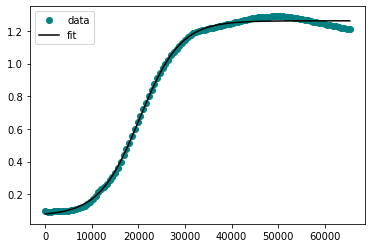

In [66]:
import pylab

#Definition of the sigmoid-function:
def sigmoid(x, L, x0, k, n):                                                       #L = curve's maximum value; x0 = x-value of the sigmoid´s midpoint (turnpoint, where the curve is linear); k = logistic growth rate or steepness of the curve (; n = value for y at x = 0)
     y = L / (1 + np.exp( -k * (x - x0))) + n
     return y

#function to find value that is closest to a given value:
def find_nearest(array, value):                                                 
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

#Well-selection
well = input("Choose Well by entering Well-name (e.g. 'A01'):")

#Curve-Fitting:
#initialize data
x_data = list(data_melted[data_melted['Well'] == well]['Time'])
y_data = list(data_melted[data_melted['Well'] == well]['Value'])

#initialize start-parameters for curve_fit
steps = (max(y_data)/1000)
half_index = int(len(x_data)/2)
x0 = data_melted[data_melted['Well'] == well].iloc[half_index, 1] 
p0 = [max(y_data), x0, steps, min(y_data)]

print(y_data, '\n', p0)

#curve_fit
popt, pcov = curve_fit(sigmoid, x_data, y_data, p0)

#get fitted function
x = np.linspace(min(x_data), max(x_data), 50)
y = sigmoid(x, *popt)

#Control-plot
#print(y)
pylab.plot(x_data, y_data, 'o', color = 'teal', label = 'data')
pylab.plot(x, y, color = 'black', label = 'fit')
pylab.legend(loc = 'best')
pylab.show()

#Creation of second dataframe
Sets up a second dataframe with the new y-values from the curve-fit for each well

In [7]:
#creates empty main-array:
fitted_data = []

#primary for-loop over all fitted values:
for wells in range(len(fitted_values)):
    
    #secondary for-loop over time-values for the actual well: 
    for position in range(len(fitted_values[wells][1])):
        
        #get well-name, time & fitted value
        well = fitted_values[wells][0]
        time = fitted_values[wells][1][position]                                        
        fitted_y = fitted_values[wells][2][position]
        
        #append data to main-array:
        fitted_data.append([well, time, fitted_y])

#creation of a second dataframe with the columns 'Well', 'Time' and 'Value' from the list 'fitted_data':
data_fitted = pd.DataFrame(fitted_data, columns = ['Well', 'Time', 'Fitted Value'])

#displays dataframe 'data_fitted':
print(data_fitted)#[data_fitted['Well'] == input("Choose well by entering the well-name (e.g.: 'A01'): ")] #Optional: only a User-chosen Well is displayed

      Well     Time  Fitted Value
0      A01      0.0      0.079380
1      A01    600.0      0.081004
2      A01   1200.0      0.082864
3      A01   1800.0      0.084993
4      A01   2400.0      0.087428
...    ...      ...           ...
10555  H12  63000.0      0.098664
10556  H12  63600.0      0.099504
10557  H12  64200.0      0.100366
10558  H12  64800.0      0.101243
10559  H12  65400.0      0.102126

[10560 rows x 3 columns]


Dataframe-merging

Merges the new y-values from data_fitted into the data_melted dataframe.

In [10]:
#create multiindex 'Well' and 'Time' for dataframe 'data_fitted':
data_fitted_multiindex = data_fitted.set_index(['Well', 'Time'], drop = True)

#check if dataframe 'data_merged' exist:
try:
    data_merged
except NameError:
    data_merged_exists = False
else:
    data_merged_exists = True

#if 'data_merged' exists:
if data_merged_exists == True: 
    
    #check if dataframe 'data_merged' already a has a column 'µ_max':
    if hasattr(data_merged, 'Fitted Value'):
    
        #if TRUE delete the column and merge 'data_µ_max' into 'data_merged':
        del data_merged['Fitted Value']
        data_merged = data_melted.join(data_fitted_multiindex, on = ['Well', 'Time'])

#if 'data_merged' doesn´t exist join 'data_µ_max' into 'data_merged':
else:
    data_merged = data_melted.join(data_fitted_multiindex, on = ['Well', 'Time'])

#display dataframe 'data_merged':
print(data_merged)#[data_merged['Well'] == input("Choose well by entering the well-name (e.g.: 'A01'): ")] #Optional: only a User-chosen Well is displayed

      Well     Time  Value  Fitted Value
0      A01      0.0  0.095      0.079380
1      A02      0.0  0.091      0.068601
2      A03      0.0  0.088      0.073835
3      A04      0.0  0.086      0.068548
4      A05      0.0  0.089      0.075256
...    ...      ...    ...           ...
10555  H08  65400.0  1.194      1.199088
10556  H09  65400.0  1.200      1.186511
10557  H10  65400.0  1.189      1.181382
10558  H11  65400.0  1.224      1.215584
10559  H12  65400.0  0.102      0.102126

[10560 rows x 4 columns]


#Plotting
Plots the growthcurves of the uploaded data together with the corresponding fitted sigmoid-function.

In [222]:
#get a list of all wells in dataframe 'data':
plate_wells = list(data_merged['Well'])

#creates empty main-array:
well_numbers = []

#for-loop over all wells in dataframe 'data_merged':
for wells in range(len(plate_wells)):
    
    #gets the number of the actual well and appends it to the array:
    well_numbers.append(plate_wells[wells][1:])

#deletes duplicates in the array:
well_numbers = list(dict.fromkeys(well_numbers))

plot_columns = int(max(well_numbers))

#deactivates the max_row limit of altair for the processed dataframe:
alt.data_transformers.enable('default', max_rows=None)

#raw-data-plot:
raw_data = alt.Chart(data_merged).mark_point(opacity=0.4, color = "teal"

#columns to plot with specifications for the axis:
).encode(
    alt.X('Time:Q', scale=alt.Scale(domain=(0, 66000)), axis=alt.Axis(title='Time [s]')),
    alt.Y('Value:Q', axis=alt.Axis(title='OD (600 nm)'))

#properties of the resulting diagramm:
).properties(
    width = 300,
    height = 200
)#.add_selection(
    #brush
#).facet(column = 'Well'
#).interactive()

#fitted-data-plot:
fitted_curves = alt.Chart(data_merged).mark_line(color = "black"
).encode(
    alt.X('Time:Q'),
    alt.Y('Fitted Value:Q')
 )

#command to layer the raw- and fitted-data-plots over each other and split them into many diagramms depending on the well:
plotted = alt.layer(raw_data, fitted_curves, data = data_merged).facet(facet = 'Well', columns = plot_columns)
plotted.save("chart.svg", scale_factor = 5.0)
plotted

alt.FacetChart(...)

#Alternative single (raw) data-plotting
Allows to choose specific Wells which shall be plotted. 

In [225]:
#Definition of the selection, which transforms the output of the upper plot by interating with the lower plot:
selection = alt.selection_multi(fields = ['Well'])

#upper plot -> plots the growthcurve of the Wells:
top = alt.Chart(data_merged).mark_line().encode(
    alt.X('Time:Q', scale=alt.Scale(domain=(0, 66000)), axis=alt.Axis(title='Time [s]')),
    alt.Y('Value:Q', scale=alt.Scale(domain=(0.0, 1.40)), axis=alt.Axis(title='OD (600 nm)')),
    color='Well:O'
).properties(
    width = 600,
    height = 500,
    title = 'Well'
).transform_filter(
    selection
)

#lower plot -> plots the Wells as dots, where the user can select a specific Well which then is plotted in the upper diagramm:
bottom = alt.Chart().mark_circle().encode(
    x= 'Well',
    color = alt.condition(selection, alt.value('steelblue'), alt.value('lightgray'))
).properties(
    width=1200, height=100
).add_selection(
    selection
)

#plot-command which fuses both plots:
alt.vconcat(
    top, bottom,
    data=data_melted
)

alt.VConcatChart(...)

#µ-calculation & Tangent-application
Determines the area of linear growth of the fitted sigmoid-curves.
For this either the user specifies an area of all curves as the linear area and the µ-values of the upper and lower boundaries are used to calculate a tangent for this area.
Or the program automatic calculates the µ-values for the fitted sigmoid-curve of each well and detects the corresponding µ_max.

µ_max is interpreted as turning point in the sigmoid-function and the tangent is applicated to this point.

In [198]:
#variables matching the possible user-input for comparison in the if-condition:
decision_positive = 'Yes'
decision_negative = 'No'

#user-decision to progress either manually or automatic:
print("This program offers you the possibility to determine the tangent for the linear area of the growth curves either manually or automatic.")
decision_manual_automatic = input("Do you want to manually set an area for the tangent-calculation? Enter Yes/No: ")

#function to find value in a given array that is closest to a given value:
def find_nearest(array, value):                                                 
    
    #converts the given list/array/... to an array:
    array = np.asarray(array)
    
    #finds the index of the array-value, which results in the lowest absolute value by subtraction with the searched value:
    idx = (np.abs(array - value)).argmin()
    
    #returns the array-value:
    return array[idx]

#check if the user want to manually perform the tangent-fitting:
if decision_manual_automatic.lower() == decision_positive.lower():
    
    #User-input of the upper and lower boundaries for the linear curve area:
    upper_boundary = float(input("Enter the upper boundary for the linear growth area of the curves (e.g. 0.6): "))
    print('\n')
    lower_boundary = float(input("Enter the lower boundary for the linear growth area of the curves (e.g. 0.4): "))

    #Well-list:
    well_plate = list(data_merged['Well'])
    well_plate = list(dict.fromkeys(well_plate))

    #creates first empty main-array:
    boundary_values = []
    
    #for-loop over all wells:
    for well in well_plate:
        
        #variable that references the 'Fitted Value'-column of dataframe data_merged:
        fitted_value_column = data_merged[data_merged['Well'] == well]['Fitted Value']
        
        #searches the nearest fitted values to the user-specified boundaries for the actual well:
        nearest_upper_boundary = find_nearest(fitted_value_column, upper_boundary)
        nearest_lower_boundary = find_nearest(fitted_value_column, lower_boundary)
        
        #searches the corresponding times to the boundary-closest fitted values:
        upper_time = data_merged[(data_merged['Well'] == well) & (data_merged['Fitted Value'] == nearest_upper_boundary)]['Time'].values[0]
        lower_time = data_merged[(data_merged['Well'] == well) & (data_merged['Fitted Value'] == nearest_lower_boundary)]['Time'].values[0]
        
        #calculates the deltas for the boundary-values:
        delta_y = (upper_boundary - lower_boundary)
        delta_x = (upper_time - lower_time)
        
        #checks if division by 0 occured:
        if delta_x > 0 or delta_x < 0:
            
            #if False µ is calculated:
            µ = (delta_y / delta_x)
        
        else:
            #if TRUE a note is written for µ:
            µ = 'division by 0'
        
        #append resulting data to first main-array:
        boundary_values.append([well, upper_boundary, upper_time, lower_boundary, lower_time, µ])
    
    #creates second empty main-array:
    computable_wells = []
    
    #checks for all wells that µ is no string:
    for well in range(len(boundary_values)):
        if type(boundary_values[well][5]) != str:
            
            #if TRUE the data for that well is appended to the second main-array:
            computable_wells.append(boundary_values[well])
    
    #creates third empty main-array:
    y0_list = []
    
    #for-loop over all wells in the second main-array:
    for well in range(len(computable_wells)):
        
        #setup initial data:
        m = float(computable_wells[well][5])
        x = float(computable_wells[well][2])
        y = float(computable_wells[well][1])
    
        #compute n from y = mx + n:
        n = (y - (m * x))

        #append data to third main-array:
        y0_list.append([computable_wells[well][0], m, n])

    #create dataframe from the resulting array:
    data = pd.DataFrame(y0_list, columns = ['Well', 'µ_max', 'y0'])
    
    #display resulting dataframe:
    print(data)

#
#
#check if the user want to autmatically perform the tangent-fitting:
if decision_manual_automatic.lower() == decision_negative.lower():
    
    #Well-list:
    well_plate = list(data_merged['Well'])
    well_plate = list(dict.fromkeys(well_plate))

    #create empty main-array:
    µ_values = []

    #primary for-loop over all wells:
    for well in well_plate:
    
        #row-count for that well as condition for secondary for-loop:
        row_count = data_merged[data_merged['Well'] == well].shape[0]
    
        #create empty arrays:
        µ = []
        time = []

        #secondary loop over all rows for that well:
        for row in range(1, row_count):
        
            #initialize data:
            actual_value = data_merged[data_merged['Well'] == well].iloc[(row - 1), 3]
            actual_time = data_merged[data_merged['Well'] == well].iloc[(row - 1), 1]
            next_value = data_merged[data_merged['Well'] == well].iloc[row, 3]
            next_time = data_merged[data_merged['Well'] == well].iloc[row, 1]
        
            #process data:
            delta_x = next_time - actual_time
            delta_y = next_value - actual_value
            m = delta_y/delta_x
        
            #append processed data to arrays:
            µ.append(m)
            time.append(next_time)
    
        #append data to main-array:
        µ_values.append([well, µ, time])

    #display resulting array:
    #µ_values

    #define function to find max µ-values in array:
    def µ_max(array):
    
        #create empty main-array:
        µ_max_list = []
    
        #primary for-loop over all wells:
        for wells in range(len(array)):
        
            #setup initial data:
            well = array[wells][0]
            µ_max = array[wells][1][0]
            µ_max_time = array[wells][2][0]
        
            #secondary for-loop over all µ-values for that well:
            for value in range(1, len(array[wells][1])):
            
                #if-condition to compare µ-values and find max µ:
                if array[wells][1][value] >= array[wells][1][(value - 1)]:
                
                    #set new µ_max and corresponding time:
                    µ_max = array[wells][1][value]
                    µ_max_time = array[wells][2][value]
        
            #append data to main-array:
            µ_max_list.append([well, µ_max_time, µ_max])
        
        return µ_max_list

    #start function µ_max with the µ_values-array:
    µ_max_list = µ_max(µ_values)

    #set Pandas display-precision to show 3 decimal places:
    pd.set_option('display.precision', 3)

    #create a dataframe from the resulting array:
    data_µ_max = pd.DataFrame(µ_max_list, columns = ['Well', 'Time', 'µ_max'])

    #display resulting dataframe:
    #print("data_µ_max: ", data_µ_max, "\n")#[data_µ_max['Well'] == input("Choose well by entering the well-name (e.g.: 'A01'): ")] #Optional: only a User-chosen Well is displayed

    #create multiindex 'Well' and 'Time' for dataframe 'data_µ_max':
    data_µ_max_multiindex = data_µ_max.set_index(['Well', 'Time'], drop = True)

    #check if dataframe 'data_merged' already a has a column 'µ_max':
    if hasattr(data_merged, 'µ_max'):
    
        #if TRUE delete the column and merge 'data_µ_max' into 'data_merged':
        del data_merged['µ_max']
        data_merged = data_merged.join(data_µ_max_multiindex, on = ['Well', 'Time'])

    #if FALSE merge 'data_µ_max' into 'data_merged':
    else:
        data_merged = data_merged.join(data_µ_max_multiindex, on = ['Well', 'Time'])

    #display dataframe 'data_merged':
    #print("data_merged:\n", data_merged, "\n")#[data_merged['Well'] == input("Choose well by entering the well-name (e.g.: 'A01'): ")] #Optional: only a User-chosen Well is displayed

    #Well-list:
    well_plate = list(data_merged['Well'])
    well_plate = list(dict.fromkeys(well_plate))

    #create empty main-array:
    y0_list = []

    #for-loop over all wells:
    for wells in well_plate:
    
        #setup initial data:
        m = data_merged[(data_merged['Well'] == wells) & (pd.notna(data_merged['µ_max']))]['µ_max'].values[0]
        x = data_merged[(data_merged['Well'] == wells) & (pd.notna(data_merged['µ_max']))]['Time'].values[0]
        y = data_merged[(data_merged['Well'] == wells) & (pd.notna(data_merged['µ_max']))]['Fitted Value'].values[0]
    
        #compute n from y = mx + n
        n = y - m * x
    
        #append data to main-array:
        y0_list.append([wells, m, n])

    #create dataframe from the resulting array:
    data = pd.DataFrame(y0_list, columns = ['Well', 'µ_max', 'y0'])

    #display dataframe 'data':
    print("data:\n", data)#[data['Well'] == input("Choose well by entering the well-name (e.g.: 'A01'):")] #Optional: only a User-chosen Well is displayed

This program offers you the possibility to determine the tangent for the linear area of the growth curves either manually or automatic.
Do you want to manually set an area for the tangent-calculation? Enter Yes/No: No
data:
    Well      µ_max     y0
0   A01  6.875e-05 -0.728
1   A02  6.161e-05 -0.643
2   A03  6.035e-05 -0.831
3   A04  5.663e-05 -1.019
4   A05  5.477e-05 -1.467
..  ...        ...    ...
91  H08  4.829e-05 -0.968
92  H09  5.304e-05 -1.340
93  H10  5.317e-05 -1.573
94  H11  5.931e-05 -2.066
95  H12  1.472e-06  0.006

[96 rows x 3 columns]


#Automatic µ_max-calculation
The automatic calculation of µ_max and a tangent in µ_max.

First for every well the µ-values over the whole fitted growth curve are calculated.

In [44]:
#Well-list:
well_plate = list(data_merged['Well'])
well_plate = list(dict.fromkeys(well_plate))

#create empty main-array:
µ_values = []

#primary for-loop over all wells:
for well in well_plate:
    
    #row-count for that well as condition for secondary for-loop:
    row_count = data_merged[data_merged['Well'] == well].shape[0]
    
    #create empty arrays:
    µ = []
    time = []

    #secondary loop over all rows for that well:
    for row in range(1, row_count):
        
        #initialize data:
        actual_value = data_merged[data_merged['Well'] == well].iloc[(row - 1), 3]
        actual_time = data_merged[data_merged['Well'] == well].iloc[(row - 1), 1]
        next_value = data_merged[data_merged['Well'] == well].iloc[row, 3]
        next_time = data_merged[data_merged['Well'] == well].iloc[row, 1]
        
        #process data:
        delta_x = next_time - actual_time
        delta_y = next_value - actual_value
        m = delta_y/delta_x
        
        #append processed data to arrays:
        µ.append(m)
        time.append(next_time)
    
    #append data to main-array:
    µ_values.append([well, µ, time])

#display resulting array:
µ_values

[['A01',
  [2.7073417446793248e-06,
   3.099828900919426e-06,
   3.5476813434010685e-06,
   4.058229489543227e-06,
   4.639624175995574e-06,
   5.300880366087996e-06,
   6.051905923444197e-06,
   6.9035080288608565e-06,
   7.867367784739158e-06,
   8.955971224696019e-06,
   1.0182482396229204e-05,
   1.1560541559568182e-05,
   1.3103969105107924e-05,
   1.4826353943929033e-05,
   1.6740504469490065e-05,
   1.8857741543787108e-05,
   2.1187017377394813e-05,
   2.373385288774769e-05,
   2.6499100439269415e-05,
   2.9477559927448827e-05,
   3.2656504544341196e-05,
   3.6014207733361116e-05,
   3.951860253260553e-05,
   4.312624405983632e-05,
   4.6781777894641014e-05,
   5.041813162740244e-05,
   5.395763262129224e-05,
   5.73142019441845e-05,
   6.0396677008568986e-05,
   6.311317686885606e-05,
   6.537625917905354e-05,
   6.710845335026546e-05,
   6.824762563073702e-05,
   6.875157414499752e-05,
   6.860129056038333e-05,
   6.78024651489234e-05,
   6.638503392797349e-05,
   6.4400828839

Finds the µ_max-valus in the resulting µ_values-array.

In [45]:
#define function to find max µ-values in array:
def µ_max(array):
    
    #create empty main-array:
    µ_max_list = []
    
    #primary for-loop over all wells:
    for wells in range(len(array)):
        
        #setup initial data:
        well = array[wells][0]
        µ_max = array[wells][1][0]
        µ_max_time = array[wells][2][0]
        
        #secondary for-loop over all µ-values for that well:
        for value in range(1, len(array[wells][1])):
            
            #if-condition to compare µ-values and find max µ:
            if array[wells][1][value] >= array[wells][1][(value - 1)]:
                
                #set new µ_max and corresponding time:
                µ_max = array[wells][1][value]
                µ_max_time = array[wells][2][value]
        
        #append data to main-array:
        µ_max_list.append([well, µ_max_time, µ_max])
    return µ_max_list

#start function µ_max with the µ_values-array:
µ_max_list = µ_max(µ_values)

#set Pandas display-precision to show 3 decimal places:
pd.set_option('display.precision', 3)

#create a dataframe from the resulting array:
data_µ_max = pd.DataFrame(µ_max_list, columns = ['Well', 'Time', 'µ_max'])

#display resulting dataframe:
data_µ_max#[data_µ_max['Well'] == input("Choose well by entering the well-name (e.g.: 'A01'): ")] #Optional: only a User-chosen Well is displayed

,Well,Time,µ_max
0,A01,20400.0,6.875e-05
1,A02,21000.0,6.161e-05
2,A03,24000.0,6.035e-05
3,A04,28200.0,5.663e-05
4,A05,37800.0,5.477e-05
...,...,...,...
91,H08,33600.0,4.829e-05
92,H09,37800.0,5.304e-05
93,H10,42000.0,5.317e-05
94,H11,46200.0,5.931e-05


Merges the µ_max-values from data_µ_max into the data_merged dataframe.

In [46]:
#create multiindex 'Well' and 'Time' for dataframe 'data_µ_max':
data_µ_max_multiindex = data_µ_max.set_index(['Well', 'Time'], drop = True)

#check if dataframe 'data_merged' already a has a column 'µ_max':
if hasattr(data_merged, 'µ_max'):
    
    #if TRUE delete the column and merge 'data_µ_max' into 'data_merged':
    del data_merged['µ_max']
    data_merged = data_merged.join(data_µ_max_multiindex, on = ['Well', 'Time'])

#if FALSE merge 'data_µ_max' into 'data_merged':
else:
    data_merged = data_merged.join(data_µ_max_multiindex, on = ['Well', 'Time'])

#display dataframe 'data_merged':
data_merged#[data_merged['Well'] == input("Choose well by entering the well-name (e.g.: 'A01'): ")] #Optional: only a User-chosen Well is displayed

,Well,Time,Value,Fitted Value,µ_max
0,A01,0.0,0.095,0.079,NaN
1,A02,0.0,0.091,0.069,NaN
2,A03,0.0,0.088,0.074,NaN
3,A04,0.0,0.086,0.069,NaN
4,A05,0.0,0.089,0.075,NaN
...,...,...,...,...,...
10555,H08,65400.0,1.194,1.199,NaN
10556,H09,65400.0,1.200,1.187,NaN
10557,H10,65400.0,1.189,1.181,NaN
10558,H11,65400.0,1.224,1.216,NaN


Tangent in µ_max:

Calculates the tangent in the point of µ_max and her intersection with the y-axis.

In [133]:
#Well-list:
well_plate = list(data_merged['Well'])
well_plate = list(dict.fromkeys(well_plate))

#create empty main-array:
y0_list = []

#for-loop over all wells:
for wells in well_plate:
    
    #setup initial data:
    m = data_merged[(data_merged['Well'] == wells) & (pd.notna(data_merged['µ_max']))]['µ_max'].values[0]
    x = data_merged[(data_merged['Well'] == wells) & (pd.notna(data_merged['µ_max']))]['Time'].values[0]
    y = data_merged[(data_merged['Well'] == wells) & (pd.notna(data_merged['µ_max']))]['Fitted Value'].values[0]
    
    #compute n from y = mx + n
    n = y - m * x
    
    #append data to main-array:
    y0_list.append([wells, m, n])

#create dataframe from the resulting array:
data = pd.DataFrame(y0_list, columns = ['Well', 'µ_max', 'y0'])

#display dataframe 'data':
data#[data['Well'] == input("Choose well by entering the well-name (e.g.: 'A01'):")] #Optional: only a User-chosen Well is displayed

,Well,µ_max,y0
0,A01,6.875e-05,-0.728
1,A02,6.161e-05,-0.643
2,A03,6.035e-05,-0.831
3,A04,5.663e-05,-1.019
4,A05,5.477e-05,-1.467
...,...,...,...
91,H08,4.829e-05,-0.968
92,H09,5.304e-05,-1.340
93,H10,5.317e-05,-1.573
94,H11,5.931e-05,-2.066


#CutOff
User-dependent input of the OD-CutOff-value.

In [13]:
cut_off = float(input("Set CutOff: "))

Set CutOff: 0.6


#SGT-Calculation

In [199]:
#row-count as condititon for following loop:
row_count = data.shape[0]

#for-loop over all rows of 'data':
for row in range(row_count):
    
    #setup initial data:
    µ_max = data.loc[row, 'µ_max']
    y0 = data.loc[row, 'y0']
    
    #compute SGT and add it to 'data':
    data.loc[row, 'SGT'] = ((cut_off - y0) / µ_max) / 60

#rounds values in SGT-column:
data['SGT'] = data['SGT'].round(decimals = 0)

#displays dataframe 'data':
data#[data['Well'] == input("Choose well by entering the well-name (e.g.: 'A01'): ")] #Optional: only a User-chosen Well is displayed

,Well,µ_max,y0,SGT
0,A01,6.875e-05,-0.728,322.0
1,A02,6.161e-05,-0.643,336.0
2,A03,6.035e-05,-0.831,395.0
3,A04,5.663e-05,-1.019,476.0
4,A05,5.477e-05,-1.467,629.0
...,...,...,...,...
91,H08,4.829e-05,-0.968,541.0
92,H09,5.304e-05,-1.340,610.0
93,H10,5.317e-05,-1.573,681.0
94,H11,5.931e-05,-2.066,749.0


#Checkerboard-layout-specification
Lets the user specify the borders of each checkerboard at his Well-plate.

In [15]:
#User-input for the checkerboard-count on their Well-Plate:
board_count = int(input('Enter the number of checkerboards at your Well-Plate: '))
print('\n')

#creates empty main-array:
checkerboards = []

#for-loop over all checkerboards in the board-count:
for board in range(board_count):
    
    #User-input of the first and last well of the specific board:
    print("For the %s. Checkerboard: " %((board + 1)))
    first_well = input("Enter the number of the first Well of the checkerboard (all antibiotic-treated wells, e.g. 'A01'): ")
    last_well = input("Enter the number of the last Well of the checkerboard (all antibiotic-treated wells, e.g. 'H12'): ")
    print('\n')

    #append data to main-array:
    checkerboards.append([board, first_well, last_well])

#User-input of the time the investigated bacteria need to grow one log-level:
log_time = int(input("Enter time (in [min]) that the investigated bacteria needs to grow one log-level (e.g.: 70): "))

#User-input of the applied antibiotics and their concentrations:
antibiotic_one_input = input("Enter name and concentrations of the first antibiotic (rising in rows), in ascending order and separated by commas (e.g.: Nitroxolin, 0, 8, 32, 64): ")
antibiotic_two_input = input("Enter name and concentrations of the second antibiotic (rising in columns), in ascending order and separated by commas (e.g.: Dalbavancin, 0, 8, 32, 64): ")

#creates lists with single elements from the user-input:
antibiotic_one = antibiotic_one_input.split(',')
antibiotic_two = antibiotic_two_input.split(',')

#initialize data:
antibiotic_one_name = str(antibiotic_one[0])
antibiotic_two_name = str(antibiotic_two[0])

Enter the number of checkerboards at your Well-Plate: 2


For the 1. Checkerboard: 
Enter the number of the first Well of the checkerboard (all antibiotic-treated wells, e.g. 'A01'): A01
Enter the number of the last Well of the checkerboard (all antibiotic-treated wells, e.g. 'H12'): G06


For the 2. Checkerboard: 
Enter the number of the first Well of the checkerboard (all antibiotic-treated wells, e.g. 'A01'): A07
Enter the number of the last Well of the checkerboard (all antibiotic-treated wells, e.g. 'H12'): G12




#log-level-Calculation
Calculates the reduction of bacterial growth in the wells in log-levels.

In [208]:
#get row-count of dataframe 'data':
row_count = data.shape[0]

#creates empty main-array
calculated_values = []

#for-loop over all checkerboards:
for boards in range(len(checkerboards)):
    
    #initialize data for if-conditions:
    first_well = str(checkerboards[boards][1])
    last_well = str(checkerboards[boards][2])
    
    #for-loop over all wells in dataframe 'data':
    for rows in range(row_count):
        
        #get name of the specific well:
        well_name = str(data.iat[rows, 0])
        
        #check if well is in the limits of the checkerboard:
        if well_name[0] >= first_well[0] and well_name[0] <= last_well[0]:
            if int(well_name[1:]) >= int(first_well[1:]) and int(well_name[1:]) <= int(last_well[1:]):
                
                #calculate data:
                SGT_subtracted_value = int(data[data['Well'] == well_name]['SGT'].values[0] 
                                      - data[data['Well'] == first_well]['SGT'].values[0])
                log_level_reduction = round((SGT_subtracted_value / log_time), 1)
                
                #determine antibiotic-concentrations:
                first_antibiotic_index = (ord(well_name[0]) - ord(first_well[0])) +1
                first_antibiotic_concentration = float(antibiotic_one[first_antibiotic_index])
                second_antibiotic_index = int(int(well_name[1:]) - ((12 / board_count) * boards))
                second_antibiotic_concentration = float(antibiotic_two[second_antibiotic_index])

                #append data to main-array:
                calculated_values.append([well_name, SGT_subtracted_value, 
                    log_level_reduction, first_antibiotic_concentration, 
                    second_antibiotic_concentration])

        elif well_name[0] <= first_well[0] or well_name[0] >= last_well[0]:
            if int(well_name[1:]) >= int(first_well[1:]) and int(well_name[1:]) <= int(last_well[1:]):
                
                #calculate data:
                SGT_subtracted_value = int(data[data['Well'] == well_name]['SGT'].values[0] 
                                      - data[data['Well'] == first_well]['SGT'].values[0])
                log_level_reduction = round((SGT_subtracted_value / log_time), 1)
                
                #determine antibiotic-concentrations:
                first_antibiotic_concentration = '-'
                second_antibiotic_concentration = '-'

                #append data to main-array:
                calculated_values.append([well_name, SGT_subtracted_value, 
                    log_level_reduction, first_antibiotic_concentration, 
                    second_antibiotic_concentration])

        elif int(well_name[1:]) <= int(first_well[1:]) or int(well_name[1:]) >= int(last_well[1:]):
            if well_name[0] >= first_well[0] and well_name[0] <= last_well[0]:
                
                #calculate data:
                SGT_subtracted_value = int(data[data['Well'] == well_name]['SGT'].values[0] 
                                      - data[data['Well'] == first_well]['SGT'].values[0])
                log_level_reduction = round((SGT_subtracted_value / log_time), 1)
                
                #determine antibiotic-concentrations:
                first_antibiotic_concentration = '-'
                second_antibiotic_concentration = '-'

                #append data to main-array:
                calculated_values.append([well_name, SGT_subtracted_value, 
                    log_level_reduction, first_antibiotic_concentration, 
                    second_antibiotic_concentration])


#creates dataframe from calculated data:
data_calculated_values = pd.DataFrame(calculated_values, columns = ['Well',
    'SGT minus control', 'log-level-reduction',
    (antibiotic_one_name + '-concentration'),
    (antibiotic_two_name + '-concentration')])

#displays dataframe 'data_calculated_values':
data_calculated_values#[data_calculated_values['Well'] == input("Choose well by entering the well-name (e.g.: 'A01'): ")] #Optional: only a User-chosen Well is displayed

Enter time (in [min]) that the investigated bacteria needs to grow one log-level (e.g.: 70): 70
Enter name and concentrations of the first antibiotic (rising in rows), in ascending order and separated by commas (e.g.: Nitroxolin, 0, 8, 32, 64): Nitroxolin, 0, 4, 8, 16, 32, 64, 128
Enter name and concentrations of the second antibiotic (rising in columns), in ascending order and separated by commas (e.g.: Dalbavancin, 0, 8, 32, 64): Dalbavancin, 0, 0.5, 1, 2, 4, 8


,Well,SGT minus control,log-level-reduction,Nitroxolin-concentration,Dalbavancin-concentration
0,A01,0,0.0,0,0
1,A02,14,0.2,0,0.5
2,A03,73,1.0,0,1
3,A04,154,2.2,0,2
4,A05,307,4.4,0,4
...,...,...,...,...,...
91,H08,146,2.1,-,-
92,H09,215,3.1,-,-
93,H10,286,4.1,-,-
94,H11,354,5.1,-,-


Merges the dataframe "data_calculated_values" into the dataframe "data":

In [209]:
#create index 'Well' for dataframe 'data_calculated_values':
data_calculated_values_index = data_calculated_values.set_index(['Well'], drop = True)

antibiotic_one_column = str(antibiotic_one_name + '-concentration')
antibiotic_two_column = str(antibiotic_two_name + '-concentration')

#check if dataframe 'data' already has the columns from dataframe 'data_calculated_values'
#if TRUE delete the columns and merge 'data_calculated_values' into 'data':
if hasattr(data, 'SGT minus control'):
    del data['SGT minus control']
    
    if hasattr(data, 'log-level-reduction'):
        del data['log-level-reduction']
        
        if hasattr(data, antibiotic_one_column):
            del data[antibiotic_one_column]
            
            if hasattr(data, antibiotic_two_column):
                del data[antibiotic_two_column]
                data = data.merge(data_calculated_values_index, on = ['Well'])
            
            else:
                data = data.merge(data_calculated_values_index, on = ['Well'])
        else:
            data = data.merge(data_calculated_values_index, on = ['Well'])
    else:
        data = data.merge(data_calculated_values_index, on = ['Well'])

#if FALSE merge 'data_calculated_values' into 'data':
else:
    data = data.merge(data_calculated_values_index, on = ['Well'])

#display dataframe 'data':
data#[data['Well'] == input("Choose well by entering the well-name (e.g.: 'A01'): ")] #Optional: only a User-chosen Well is displayed

,Well,µ_max,y0,SGT,SGT minus control,log-level-reduction,Nitroxolin-concentration,Dalbavancin-concentration
0,A01,6.875e-05,-0.728,322.0,0,0.0,0,0
1,A02,6.161e-05,-0.643,336.0,14,0.2,0,0.5
2,A03,6.035e-05,-0.831,395.0,73,1.0,0,1
3,A04,5.663e-05,-1.019,476.0,154,2.2,0,2
4,A05,5.477e-05,-1.467,629.0,307,4.4,0,4
...,...,...,...,...,...,...,...,...
91,H08,4.829e-05,-0.968,541.0,146,2.1,-,-
92,H09,5.304e-05,-1.340,610.0,215,3.1,-,-
93,H10,5.317e-05,-1.573,681.0,286,4.1,-,-
94,H11,5.931e-05,-2.066,749.0,354,5.1,-,-


#Determination of BBC-wells:
Searches the wells which contain only a single antibiotic (concentration of the second antibiotic = 0) for the lowest concentration of this antibiotic that reached a log-level-reduction >= 3, which equates the biofilm-bacterizidal concentration (BBC) of this antibiotic.

BBC = Minimal concentration of an antibiotic that reached reduction >= 3 log-levels.

In [210]:
#get row-count of dataframe 'data':
row_count = data.shape[0]

#creates empty main-arrays:
first_antibiotic_bbcs = []
second_antibiotic_bbcs = []

#for-loop over all checkerboards:
for boards in range(len(checkerboards)):
    
    #creates empty array:
    first_antibiotic_concentrations =[]

    #initialize data for if-conditions:
    first_well = str(checkerboards[boards][1])
    last_well = str(checkerboards[boards][2])
        
    #for-loop over all wells in dataframe 'data':
    for rows in range(row_count):
        
        #get name of the specific well:
        well_name = str(data.iat[rows, 0])
        
        #check if well is within the limits of the checkerboard and accomplishs the log-level-reduction:
        if well_name[1:] == first_well[1:]:
            if well_name[0] >= first_well[0] and well_name[0] <= last_well[0]:
                if data[data['Well'] == well_name]['log-level-reduction'].values[0] >= 3.0:
                    
                    #get concentration of the first antibiotic in this well:
                    first_antibiotic_concentrations.append(data.loc[rows, antibiotic_one_column])

    #append data to main-array:
    first_antibiotic_bbcs.append(first_antibiotic_concentrations)

#for-loop over all checkerboards:
for boards in range(len(checkerboards)):
    
    #creates empty array
    second_antibiotic_concentrations = []

    #initialize data for if-conditions:
    first_well = str(checkerboards[boards][1])
    last_well = str(checkerboards[boards][2])
        
    #for-loop over all wells in dataframe 'data':
    for rows in range(row_count):
        
        #get name of the specific well:
        well_name = str(data.iat[rows, 0])
        
        #check if well is within the limits of the checkerboard and accomplishs the log-level-reduction:
        if well_name[0] == first_well[0]:
            if well_name[1:] >= first_well[1:] and well_name[1:] <= last_well[1:]:
                if data[data['Well'] == well_name]['log-level-reduction'].values[0] >= 3.0:
                    
                    #get concentration of the second antibiotic in this well:
                    second_antibiotic_concentrations.append(data.loc[rows, antibiotic_two_column])

    #append data to main-array:
    second_antibiotic_bbcs.append(second_antibiotic_concentrations)

#displays both main-arrays:
print(first_antibiotic_bbcs, second_antibiotic_bbcs)

#create new empty main-arrays:
first_antibiotic_bbc = []
second_antibiotic_bbc = []

#for-loop over all checkerboards:
for boards in range(len(checkerboards)):
    
    #append corresponding data from first main-arrays to new main-arrays:
    first_antibiotic_bbc.append(first_antibiotic_bbcs[boards][0])
    second_antibiotic_bbc.append(second_antibiotic_bbcs[boards][0])

#displays new main-arrays:
print(first_antibiotic_bbc, second_antibiotic_bbc)    


[[64.0, 128.0], [64.0, 128.0]] [[4.0, 8.0], [4.0, 8.0]]
[64.0, 64.0] [4.0, 4.0]


#Determination of Synergism
Determines if a synergism between the two tested antibiotics exist.

First the FICI (fractional inhibitory concentration index)-values are calculated for all wells with an log-level-reduction >= 3. 

In [211]:
#get row-count of dataframe 'data':
row_count = data.shape[0]

#creates empty main-array:
fici_values = []

#for-loop over all checkerboards:
for boards in range(len(checkerboards)):
    
    #initialize data for if-conditions:
    first_well = str(checkerboards[boards][1])
    last_well = str(checkerboards[boards][2])
    
    #initialize data for computation:
    antibiotic_one_bbc = first_antibiotic_bbc[boards]
    antibiotic_two_bbc = second_antibiotic_bbc[boards]
    
    #creates empty arrays:
    fici_value_per_well = []
    wells = []

    #for-loop over all wells in dataframe 'data':
    for rows in range(row_count):
        
        #get name of the specific well:
        well_name = str(data.iat[rows, 0])
        
        #check if well is in the limits of the checkerboarda and the log-level-reduction is >= 3:
        if well_name[0] > first_well[0] and well_name[0] <= last_well[0]:
            if int(well_name[1:]) > int(first_well[1:]) and int(well_name[1:]) <= int(last_well[1:]):
                if data[data['Well'] == well_name]['log-level-reduction'].values[0] >= 3.0:
                    actual_first_antibiotic_concentration = data[data['Well'] == well_name][antibiotic_one_column].values[0]
                    actual_second_antibiotic_concentration = data[data['Well'] == well_name][antibiotic_two_column].values[0]
                    well_fici_value = ((actual_first_antibiotic_concentration/antibiotic_one_bbc) + (actual_second_antibiotic_concentration/antibiotic_two_bbc))
                    
                    #append data to arrays:
                    wells.append(str(well_name))
                    fici_value_per_well.append(well_fici_value)

    #append arrays in main-array:
    fici_values.append([wells, fici_value_per_well])

#displays main-array:
print(fici_values)

[[['B04', 'B05', 'B06', 'C04', 'C05', 'C06', 'D04', 'D05', 'D06', 'E02', 'E03', 'E04', 'E05', 'E06', 'F02', 'F03', 'F04', 'F05', 'F06', 'G02', 'G03', 'G04', 'G05', 'G06'], [0.5625, 1.0625, 2.0625, 0.625, 1.125, 2.125, 0.75, 1.25, 2.25, 0.625, 0.75, 1.0, 1.5, 2.5, 1.125, 1.25, 1.5, 2.0, 3.0, 2.125, 2.25, 2.5, 3.0, 4.0]], [['B11', 'B12', 'C11', 'C12', 'D10', 'D11', 'D12', 'E09', 'E10', 'E11', 'E12', 'F08', 'F09', 'F10', 'F11', 'F12', 'G08', 'G09', 'G10', 'G11', 'G12'], [1.0625, 2.0625, 1.125, 2.125, 0.75, 1.25, 2.25, 0.75, 1.0, 1.5, 2.5, 1.125, 1.25, 1.5, 2.0, 3.0, 2.125, 2.25, 2.5, 3.0, 4.0]]]


Then from this wells the first of each row and column are identified.

In [212]:
#defines a function which seeks the first letter in alphabetical order and the smallest number in an given list of well-names:
def well_naming(array):
    
    #sets the letter and number of thefirst well in the list:
    well_letter = array[0][0]
    well_number = array[0][1:]
    
    #tests for all wells of the list if the letter and number are smaller and if true sets them es new minimal value:
    for wells in range(len(array)):
        if array[wells][0] < well_letter:
            well_letter = array[wells][0]
        if array[wells][1:] < well_number:
            well_number = array[wells][1:]
    
    #returns the minimal letter and number of all wells:
    return well_letter, well_number

#get a list of all wells in dataframe 'data':
plate_wells = list(data['Well'])

#creates empty main-arrays:
well_letters = []
well_numbers = []
first_wells_in_rows_and_columns = []

#for-loop over all wells in dataframe 'data':
for wells in range(len(plate_wells)):
    
    #gets the letter and number of the actual well and appends them to the arrays:
    well_letters.append(plate_wells[wells][0])
    well_numbers.append(plate_wells[wells][1:])

#deletes duplicates in the arrays:
well_letters = list(dict.fromkeys(well_letters))
well_numbers = list(dict.fromkeys(well_numbers))

#for_loop over all checkerboards:
for boards in range(len(checkerboards)):
    
    #creates empty arrays:
    first_well_in_row = []
    first_well_in_column = []
    
    #gets the wells with an log-level-reduction >= 3:
    wells = fici_values[boards][0]
    
    #searches the minimal letter and number of this wells:
    well_min_letter_and_number = well_naming(wells)
    
    #for-loop over all letters that are part of an well-name in dataframe 'data':
    for letters in range(len(well_letters)):
        
        #takes the actual letter and searches the well-list for all wells with the letter in their name:
        letter = well_letters[letters]
        well_selection = [s for s in wells if letter in s]
        
        #checks if wells which names contain the letter were found:
        if len(well_selection) > 0:
            
            #gets the "smallest" of the selected ones (the first for this row) and appends it to the array:
            first_well = min(well_selection)
            first_well_in_row.append(first_well)
            
            #checks if the array contains a well with the minimal number in it´s name:
            end_well_number = well_min_letter_and_number[1]
            if first_well_in_row[-1][1:] == end_well_number:   
                
                #if TRUE the loop is interrupted
                break
    
    #for-loop over all numbers that are part of an well-name in dataframe 'data':
    for numbers in range(len(well_numbers)):
        
        #takes the actual number and searches the well-list for all wells with the number in their name:
        number = well_numbers[numbers]
        well_selection = [s for s in wells if number in s]
        
        #checks if wells which names contain the number were found:
        if len(well_selection) > 0:
            
            #gets the "smallest" of the selected ones (the first for this column) and appends it to the array:
            first_well = min(well_selection)
            first_well_in_column.append(first_well)
            
            #checks if the array contains a well with the minimal letter in it´s name:
            end_well_letter = well_min_letter_and_number[0]
            if first_well_in_column[-1][0] == end_well_letter:   
                
                #if TRUE the loop is interrupted
                break
    
    #extend the row-array with the column-array:
    first_well_in_row.extend(first_well_in_column)
    
    #deletes all duplicates in the extended row-array and saves it as new variable:
    first_wells_in_rows_and_columns.append(list(dict.fromkeys(first_well_in_row)))

#displays the resulting array:   
print(first_wells_in_rows_and_columns)

[['B04', 'C04', 'D04', 'E02', 'E03'], ['B11', 'C11', 'D10', 'E09', 'F08']]


For the first wells of each row and column of the checkerboard the average of the FICI-values is determined, which allows a statement about an possible synergism between the two antibiotics. 

In [213]:
#creates empty main-arrays:
board_fici_values = []
board_fici_values_with_well = []

#for-loop over all checkerboards:
for boards in range(len(checkerboards)):
    
    #create empty arrays:
    corresponding_fici_value = []
    corresponding_fici_value_with_well = []
    
    #for-loop over all wells that are the first well of a row/column at that checkerboard:
    for wells in range(len(first_wells_in_rows_and_columns[boards])):
        
        #searches the index of the actual well in the fici-values-array:
        well_index = fici_values[boards][0].index(first_wells_in_rows_and_columns[boards][wells])
        
        #appends the fici_value which corresponds to this index to the arrays:
        corresponding_fici_value.append(fici_values[boards][1][well_index])
        corresponding_fici_value_with_well.append([first_wells_in_rows_and_columns[boards][wells], fici_values[boards][1][well_index]])
    
    #appends data to the main-arrays:
    board_fici_values.append(corresponding_fici_value)
    board_fici_values_with_well.append(corresponding_fici_value_with_well)

#creates new main-array:
fici_average = []

#for-loop over all checkerboards:
for boards in range(len(checkerboards)):
    
    #computes the average of the fici-values of the first wells in all rows and columns of the checkerboard:
    fici_average.append(np.average(board_fici_values[boards]))

#displays the resulting arrays:
for boards in range(len(checkerboards)):
    print("First wells of all rows and columns of Checkerboard %s with an log-level-reduction >= 3 and their corresponding FICI-value:"
    %(boards + 1), '\n',
    board_fici_values_with_well[boards],
    '\n',
    "The average of the FICI-values for this board is: ",
    fici_average[boards],
    '\n')

First wells of all rows and columns of Checkerboard 1 with an log-level-reduction >= 3 and their corresponding FICI-value: 
 [['B04', 0.5625], ['C04', 0.625], ['D04', 0.75], ['E02', 0.625], ['E03', 0.75]] 
 The average of the FICI-values for this board is:  0.6625 

First wells of all rows and columns of Checkerboard 2 with an log-level-reduction >= 3 and their corresponding FICI-value: 
 [['B11', 1.0625], ['C11', 1.125], ['D10', 0.75], ['E09', 0.75], ['F08', 1.125]] 
 The average of the FICI-values for this board is:  0.9625 



#Summarise resuls in file and download

In [215]:
#creates copy of dataframe 'data':
data_results = data.copy()

#checks if the new dataframe contains the columns 'µ_max' & 'y0' and deletes them if TRUE:
if hasattr(data_results, 'µ_max'):
    del data_results['µ_max']
    
    if hasattr(data_results, 'y0'):
        del data_results['y0']

#reorders the columns of the dataframe:
data_results_columns = list(data_results.columns)
new_columns_order = [data_results_columns[0], data_results_columns[-2], data_results_columns[-1]]
new_columns_order.extend(data_results_columns[1:-2])
data_results = data_results[new_columns_order]

#creates empty dictionary:
checkerboard_dict = {}

#get row-count of dataframe 'data_results':
row_count = data_results.shape[0]

#for-loop over all checkerboards:
for boards in range(len(checkerboards)):

    #initialize data for if-conditions:
    first_well = str(checkerboards[boards][1])
    last_well = str(checkerboards[boards][2])

    #creates empty array:
    well_list = []
    
    #for-loop over all wells in dataframe 'data_results':
    for rows in range(row_count):
        
        #get name of the specific well:
        well_name = str(data_results.iat[rows, 0])
        
        #check if well is within the limits of the checkerboard and accomplishs the log-level-reduction:
        if well_name[0] >= first_well[0] and well_name[0] <= last_well[0]:
            if well_name[1:] >= first_well[1:] and well_name[1:] <= last_well[1:]:

                #if TRUE append well to list:
                well_list.append(well_name)
        
        elif well_name[0] <= first_well[0] or well_name[0] >= last_well[0]:
            if well_name[1:] >= first_well[1:] and well_name[1:] <= last_well[1:]:
                
                #if TRUE append well to list:
                well_list.append(well_name)
        
        elif well_name[1:] <= first_well[1:] or well_name[1:] >= last_well[1:]:
            if well_name[0] <= first_well[0] or well_name[0] >= last_well[0]:
                
                #if TRUE append well to list:
                well_list.append(well_name)
    
    #creates copy of dataframe 'data_results':
    data_results_copy = data_results.copy()

    #gets actual index + 1:
    boards_index = (boards + 1)
    
    #checks if the index is < 10:
    if boards_index < 10:
        
        #if TRUE a 0 is added in front of the index and the so numbered Checkerboard is used as key in the dicitionary which references the dataframe 'data_results_copy' without all rows whose well wasn´t in well_list. Sets the column with the well-names as index:
        checkerboard_dict["Checkerboard_0{0}".format(boards_index)] = data_results_copy.drop(data_results_copy[data_results_copy.Well.isin(well_list) == False].index).set_index('Well', drop = True).to_markdown()
    
    elif boards_index >= 10:
        
        #if FALSE the  Checkerboard is just numbered with the index and used as key in the dicitionary which references the dataframe 'data_results_copy' without all rows whose well wasn´t in well_list. Sets the column with the well-names as index:
        checkerboard_dict["Checkerboard_{0}".format(boards_index)] = data_results_copy.drop(data_results_copy[data_results_copy.Well.isin(well_list) == False].index).set_index('Well', drop = True).to_markdown()

#displays the actual key (Checkerboard-name) and the corresponding value (= dataframe) of the dictionary:
for keys in range(len(checkerboard_dict)):
    actual_key = list(checkerboard_dict)[keys]
    #print(actual_key, '\n', checkerboard_dict[actual_key], '\n')

    result_md = checkerboard_dict[actual_key]

    result_file = open("result.md", "a")
    result_file.write('## ')
    result_file.write(actual_key)
    result_file.write('\n')
    result_file.write(result_md)
    result_file.write('\n\n')
    result_file.close()



In [223]:
from google.colab import files
files.download('result.md')
files.download('chart.svg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [167]:
import os
os.remove("result.md")

#Code-Base
Code saved for later use.

In [ ]:
#Initialization and import-commands
!pip install pdvega #installs pdvega
!jupyter nbextension install --sys-prefix --py vega3 #prepares a notebook to work with vega(?)

#if cell == "Programm: Tecan i-control":
      #num_rows = worksheet.num_rows - 1
      #curr_row = -1
      #while curr_row < num_rows:
        #if worksheet.cell(curr_row, 0) == comp_list:
          #curr_row += 1

        #else:
          #curr_row += 1
    #else:
       #data_xls = pd.read_excel (fn, sheet_name=0)
       #data_xls.to_csv ('output.csv', encoding='utf-8')
       #!head -n -5 output.csv


out = subprocess.Popen(['wc', '-l', 'my_text_file.txt'], 
           stdout=subprocess.PIPE, 
           stderr=subprocess.STDOUT)

#handling Excel-files
workbook = rd.open_workbook(fn) #define variable which refers to the Excel-file named "fn"
worksheet = workbook.sheet_by_index(0) #define variable which refers to the worksheet with index [0] inside the Excel-file saved in variable "workbook"
print(worksheet.row_values(0, 0, 1))
print(worksheet.nrows) #prints the row-count for the Excel-sheet referenced by the variable "worksheet"

#Pandas-Dataframe:
#Create panda dataframe
data = {'name': ['Jason', 'Molly', 'Tina', 'Jake', 'Amy'], 'year': [2012, 2012, 2013, 2014, 2014], 'reports': [4, 24, 31, 2, 3]} #creates a dataframe with the columns "name", "year" and "reports" with the associated values
df = pd.DataFrame(data, index = ['Cochice', 'Pima', 'Santa Cruz', 'Maricopa', 'Yuma']) #sets the row-indexes to the names, defined in the command

df.loc[-1] = [2, 3, 4]  # adding a row at index [-1] with the values 2, 3 & 4
df.index = df.index + 1  # shifting index (adding 1)
df = df.sort_index()  # sorting by index, used with the two commands before to add new rows to a dataframe (as first row)

df[:-3] #drop bottom 3 lines of a panda dataframe named df
list(data.index.values) #lists the indexes of the panda data frame
data = data.set_index('Data', drop = True) #sets the column with the name 'Data' as new index for the data frame
data.reset_index(level=0, inplace=True) #integrates the index column as new column with the index [0] 
list(data.columns) #lists the names of the columns of a panda data frame
data = data.rename(columns={'index': 'Time'}) #renames the column 'index' to 'Time'
data.iloc[0,0] #gives the value of the dataframe cell with the index [0, 0] (row, column), alternativly use data.loc[''] to search for a index name
type(data.iat[4,5]) #gives the type of the value of an panda data frame cell back
data = data.astype(float) #changes the datatype of all values in the dataframe to float
data = data.transpose() #transpose the dataframe
data_melted.groupby('Well')['Value'].max() #searches max-Value for every ID (here 'Well')
data_melted.groupby('Well')['Time'].median() #searches median for every ID (here 'Well')
data_results = data.copy() #creates a copy of the dataframe 'data' which contains all indexes and data

y_median = data_melted[data_melted['Well'] == well]['Value'].median()       #computes the median of the "Value"-column for the specified Well
pos = find_nearest(data_melted[data_melted['Well'] == well]['Value'], y_median) #uses the function "find_nearest" to search the value in the "Value"-column of the specified Well which is closest to the computed median
x_median = data_melted.loc[(data_melted['Well'] == well) & (data_melted['Value'] == pos)].values[0][1]                               #gives the index of the cell with the value closest to the median #gives the time-value associated to the median of the "Value"-column     

#User-specified Plotting -> plots the diagramms for specific Wells which the user defines via input.
#deactivates the max_row limit of altair for the processed dataframe:
alt.data_transformers.enable('default', max_rows=None)

#Plot-command, where the 'Time'- & 'Value'-values for user-specified IDs (specified under .facet(column = 'Well')) are plotted in different diagramms:
chart = alt.Chart(data_melted).mark_line(color = "black").encode(
    alt.X('Time:Q', scale=alt.Scale(domain=(0, 66000)), axis=alt.Axis(title='Time [s]')),
    alt.Y('Value:Q', axis=alt.Axis(title='OD (600 nm)'))
).properties(
    width = 300,
    height = 200
).transform_filter(
    (alt.datum.Well == input("Enter Well-description for first diagramm (e. g.: A01):")) | (alt.datum.Well == input("Enter Well-description for second diagramm (e. g.: A01):"))
)

chart.facet(column = 'Well')

##
import string

letter_list = list(string.ascii_uppercase)
number_list = np.linspace(1, 50, 50)
possible_wells = []
for letter in letter_list:
    for number in number_list:
        if int(number) < 10:
            possible_well = letter + '0' + str(int(number))
            possible_wells.append(possible_well)
        
        else:
            possible_well = letter + str(int(number))
            possible_wells.append(possible_well)
##



from google.colab import files
files.download('data.csv')
